# Postprocessing for the eigenvalue solutions

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, h5py, pickle
from pg_utils.processing import postproc as pproc
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import params
from pg_utils.numerics import utils as nutils
from sympy import srepr, parse_expr

---
## Eigenvalue comparison

Read in eigenvalue solutions

In [136]:
solution_file_list = [
    
    # # Different recipes for Malkus bg field
    # "./out/solutions/Malkus/Eigen_recipe-Daria_mm.hdf5", 
    # "./out/solutions/Malkus/Eigen_recipe-Daria.h5", 
    # "./out/solutions/Malkus/Eigen_recipe-Daria_scipy.h5", 
    # "./out/cases/Malkus/MM_recipe/Eigen.h5",
    # "./out/cases/Malkus/MM_quad_Malkus/Eigen.h5",
    
    # # Final three approaches for Malkus bg field
    # "./out/cases/Malkus/Full_recipe_Daria_thesis/Eigen.h5",
    # "./out/cases/Malkus/Conjugate_recipe/Eigen.h5", 
    # "./out/eigen/Malkus/Transformed/eigen_m3_N5.h5",
    # "./out/cases/Malkus/Reduced_sys/Eigen.h5",
    # "./out/eigen/Malkus/Reduced/eigen_m3_N5.h5"
    
    # Malkus bg field
    # "./out/eigen/Malkus/Original/eigen_m3_N50.h5",
    # "./out/eigen/Malkus/Transformed/eigen_m1_N50.h5",
    # "./out/archived/Malkus/Conjugate_recipe/Eigen_N100.h5",
    "./out/eigen/Malkus/Reduced/eigen_m3_N50.h5",
    # "./out/eigen/Malkus/Reduced/eigen_m3_N50_cpt.h5",
    # "./out/eigen/Malkus/Reduced/eigen_m3_N50_quad-eigen-p113.h5",
    # "./out/eigen/Malkus/Reduced/eigen_m3_N50_quad-eigen-p113.pkl",
    "./out/eigen/Malkus/Reduced/eigen_m3_N50_quad-eigen-p113_chop.pkl",
    
    # Hydrodynamic modes
    # "./out/eigen/Hydrodynamic/Transformed/eigen_m3_N50.h5",
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m3_N50.h5",
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m3_N50_quad-eigen-p113.h5",
    
    # Toroidal quadrupolar modes
    # "./out/eigen/Toroidal_Quadrupole/Transformed/eigen_m3_N50.h5",
    # "./out/eigen/Toroidal_Quadrupole/Reduced/eigen_m3_N50.h5",
    
    # Poloidal dipolar modes
    # "./out/eigen/Poloidal_Dipole/Transformed/eigen_m3_N50.h5",
    # "./out/eigen/Poloidal_Dipole/Reduced/eigen_m3_N50.h5"
]
src_names = [
    
    # # Different recipes for Malkus bg field
    # "Code Daria Mathematica", 
    # "PlesioGeostroPy-mp32", 
    # "PlesioGeostroPy-scipy", 
    # "PlesioGeostroPy-PG-Daria",
    # "PlesioGeostroPy: Recipe Daria quad_Malkus",
    
    # # Final three approaches for Malkus bg field
    # "Recipe Holdenried-Chernoff (2021)",
    # "Transformed variables", 
    # "Conjugate variables (Unitary)", 
    # "Reduced system",
    # "Reduced system (v2)",
    "Naive diagonal F_ext",
    "Compact F_ext",
    # "Double precision",
    # "Quadruple precision",
    # "Quadruple precision (chopped)",
    
    # Hydrodynamic modes
    # "Conjugate variables",
    # "Reduced system",
    
    # Toroidal quadrupolar modes
    # "Transformed variables",
    # "Reduced system",
]

solution_list = list()
for idx, fname in enumerate(solution_file_list):
    if fname.split('.')[-1] == "h5":
        with h5py.File(fname, 'r') as fread:
            solution_list.append(fread["eigval"][()])
            if "azm" in fread.attrs.keys():
                azm_val = fread.attrs["azm"]
                Le_val = fread.attrs["Le"]
            else:
                azm_val = fread.attrs[srepr(xpd.m)]
                Le_val = fread.attrs[srepr(params.Le)]
    elif fname.split('.')[-1] == "pkl":
        with open(fname, 'rb') as fread:
            serialized_obj = pickle.load(fread)
            solution_list.append(serialized_obj["eigval"])
            azm_val = serialized_obj["meta"][srepr(xpd.m)]
            Le_val = serialized_obj["meta"][srepr(params.Le)]

if "Mathematica" in src_names[0].split():
    solution_list[0] = 1j*solution_list[0]

Only if you want to convert everything to multi-prec:

In [135]:
solution_list = [nutils.to_gpmy2_c(eig_tmp, prec=113) for eig_tmp in solution_list]

### Sorting eigenmodes

East/west splitting. The following code block classifies the eigenvalues into
1. Eastwards modes and their eigenvalues (imaginary part smaller than a negative threshold)
2. Westwards modes and their eigenvalues (imaginary part greater than a positive threshold)

In [124]:
# func_collections = [
#     lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=-1e-7, transform_filter=np.imag, transform_sort=np.imag),
#     lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=+1e-7, transform_filter=np.imag, transform_sort=np.imag)
# ]
func_collections = [
    lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=-1e-7, transform_filter=lambda x: np.imag(x.astype(np.complex128)), transform_sort=lambda x: np.imag(x.astype(np.complex128))),
    lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=+1e-7, transform_filter=lambda x: np.imag(x.astype(np.complex128)), transform_sort=lambda x: np.imag(x.astype(np.complex128)))
]

Fast/slow splitting. The following code block classifies the eigenvalues into
1. Fast modes and their eigenvalues (absolute value of imaginary part greater than a threshold)
2. Slow modes and their eigenvalues (absolute value of imaginary part less than a threshold)

In [75]:
func_colletions = [
    lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=1e+1, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), reversed=True),
    lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=1e+1, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), remove_zero=1e-9)
]

Collect the results according to the classification criterion

In [125]:
df_colletions = [pd.DataFrame() for func in func_collections]
uniform_trunc = [51 for func in func_collections]
for i_src, srcname in enumerate(src_names):
    eig_vals_classes = pproc.classify_eigens_criteria(solution_list[i_src], func_collections)
    eig_vals_classes = [eig_class[0] for eig_class in eig_vals_classes]
    for i_df, dftmp in enumerate(df_colletions):
        dftmp[srcname] = eig_vals_classes[i_df][:uniform_trunc[i_df]]

### Add reference solution

If exists, the analytic solutions can be added.

In [126]:
from pg_utils.numerics import utils as nutils
import gmpy2 as gp

n_eigs = np.arange(1, 52)

# Malkus modes

omega_fast, omega_slow = nutils.eigenfreq_Malkus_pg(3, n_eigs, 1e-4, timescale="alfven", prec=113)
# omega_fast, omega_slow = nutils.eigenfreq_Malkus_pg(gp.mpfr(3, 113), nutils.to_gpmy2_f(n_eigs, prec=113), gp.mpfr("0.0001", 113), timescale="alfven", prec=113)
df_colletions[0]["Analytic PG"] = omega_fast.astype(np.complex128)*1j
df_colletions[1]["Analytic PG"] = omega_slow.astype(np.complex128)*1j
# Multi-prec
# with gp.local_context(gp.context(), precision=113):
#     df_colletions[0]["Analytic PG"] = omega_fast*1j
#     df_colletions[1]["Analytic PG"] = omega_slow*1j

omega_fast, omega_slow = nutils.eigenfreq_Malkus_3d(3, n_eigs, 1e-4, timescale="alfven")
df_colletions[0]["Analytic 3D"] = omega_fast*1j
df_colletions[1]["Analytic 3D"] = omega_slow*1j

# Inertial modes

# omega_inertial = nutils.eigenfreq_psi_op(3, n_eigs)
# df_colletions[0]["Analytic PG"] = omega_inertial*1j

# omega_inertial_3d = nutils.eigenfreq_inertial3d(3, n_eigs)
# df_colletions[0]["Analytic 3D"] = omega_inertial_3d*1j

In [127]:
df_colletions[0].style.format(formatter=lambda x: "{0.real:.2e},{0.imag:.25e}j".format(x))

,Naive diagonal F_ext,Compact F_ext,Analytic PG,Analytic 3D
0,"0.00e+00,-2.3529453014633563725510612e+03j","0.00e+00,-2.3529453014633563725510612e+03j","-0.00e+00,-2.3529453014633568272984121e+03j","-0.00e+00,-2.5319765019567093986552209e+03j"
1,"1.18e-14,-1.1650565686340451065916568e+03j","-1.43e-14,-1.1650565686340444244706305e+03j","-0.00e+00,-1.1650565686340439697232796e+03j","-0.00e+00,-1.1874051950730804492195603e+03j"
2,"0.00e+00,-7.0176751071944329396501416e+02j","0.00e+00,-7.0176751071944408977287821e+02j","-0.00e+00,-7.0176751071944295290450100e+02j","-0.00e+00,-7.0680027675241865381394746e+02j"
3,"-5.68e-14,-4.7060765949235650396076380e+02j","5.68e-14,-4.7060765949235837979358621e+02j","-0.00e+00,-4.7060765949235621974366950e+02j","-0.00e+00,-4.7215531651149490244279150e+02j"
4,"5.68e-14,-3.3805509186976553337444784e+02j","-5.68e-14,-3.3805509186976718183359480e+02j","-0.00e+00,-3.3805509186976570390470442e+02j","-0.00e+00,-3.3863603355642629821886658e+02j"
5,"5.68e-14,-2.5481269008371072004592861e+02j","-2.84e-14,-2.5481269008371083373276633e+02j","-0.00e+00,-2.5481269008370992423806456e+02j","-0.00e+00,-2.5506357083877725244747126e+02j"
6,"-2.84e-14,-1.9905048971469960861213622e+02j","-5.35e-14,-1.9905048971469955176871736e+02j","-0.00e+00,-1.9905048971469898333452875e+02j","-0.00e+00,-1.9917076062974754790957377e+02j"
7,"5.68e-14,-1.5984355567990553481649840e+02j","2.84e-14,-1.5984355567990544955137011e+02j","-0.00e+00,-1.5984355567990530744282296e+02j","-0.00e+00,-1.5990607853771689406130463e+02j"
8,"-3.86e-22,-1.3121642979788259708584519e+02j","-6.74e-22,-1.3121642979788165916943399e+02j","-0.00e+00,-1.3121642979788245497729804e+02j","-0.00e+00,-1.3125110664756959977239603e+02j"
9,"1.42e-14,-1.0967140419480986679445778e+02j","-1.42e-14,-1.0967140419480990942702192e+02j","-0.00e+00,-1.0967140419480982416189363e+02j","-0.00e+00,-1.0969168324034970396496647e+02j"


Additionally, compute the difference from reference

In [128]:
df_compare = df_colletions[0]
ref_name = "Analytic PG"

df_compare_err = pd.DataFrame()
for idx, srcname in enumerate(src_names):
    df_compare_err[srcname] = np.abs(df_compare[ref_name] - df_compare[srcname])/np.abs(df_compare[ref_name])

df_compare_err.style.format(formatter=lambda x: "{:.7e}".format(x))

,Naive diagonal F_ext,Compact F_ext
0,1.9326729e-16,1.9326729e-16
1,9.7585783e-16,3.9051424e-16
2,4.8600214e-16,1.6200071e-15
3,6.1589669e-16,4.5915056e-15
4,5.3173189e-16,4.3750905e-15
5,3.1310662e-15,3.5710101e-15
6,3.1445450e-15,2.8683311e-15
7,1.4662551e-15,9.0665432e-16
8,1.0830088e-15,6.0648492e-15
9,4.0975788e-16,7.8818395e-16


### Eigenvalue plot

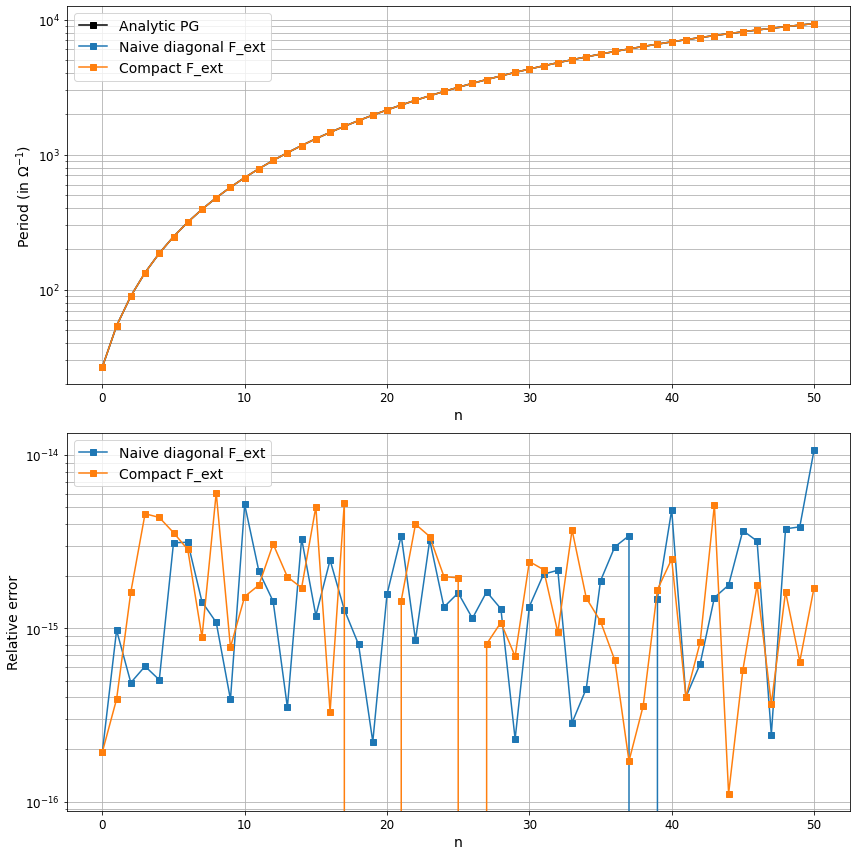

In [129]:
df_view = df_colletions[0]
ref_name = "Analytic PG"
df_err_view = pd.DataFrame()
for idx, srcname in enumerate(src_names):
    # df_err_view[srcname] = np.abs(df_view[ref_name] - df_view[srcname])/np.abs(df_view[ref_name])
    df_err_view[srcname] = np.abs(np.imag((df_view[ref_name] - df_view[srcname]).astype(np.complex_)))/np.abs(np.imag(df_view[ref_name].astype(np.complex_)))
n_view = 51

# save_name = "./out/eigen/Hydrodynamic/Analytical_error"
# save_name = "./out/eigen/Malkus/Reduced/Analytical_error_precision_slow"
save_name = None
override = True

if df_err_view is None:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    ax = axes
else:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
    ax = axes[0]

# Use if Alfven time scale is used
scale = 1/Le_val
# Use if rotation time scale is used
# scale = 1

ax.semilogy(np.arange(n_view), 2*np.pi*scale/np.abs(np.imag(df_view[ref_name].iloc[:n_view].astype(np.complex_))), 'ks-', label=ref_name)
for idx, srcname in enumerate(src_names):
    ax.semilogy(np.arange(n_view), 2*np.pi*scale/np.abs(np.imag(df_view[srcname][:n_view].astype(np.complex_))), 's-', label=srcname)
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_xlabel("n", fontsize=14)
ax.set_ylabel("Period (in $\Omega^{-1}$)", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

if df_err_view is not None:
    ax = axes[1]
    for idx, srcname in enumerate(src_names):
        ax.semilogy(np.arange(n_view), df_err_view[srcname][:n_view], 's-', label=srcname)
    ax.grid(which="both")
    ax.legend(fontsize=14)
    ax.set_xlabel("n", fontsize=14)
    ax.set_ylabel("Relative error", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.set_ylim([1e-17, 1e-12])

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.pdf') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.pdf', format="pdf", bbox_inches="tight")
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")
plt.show()

---
## Eigenmode visualization

Reading data

In [27]:
from scipy import special as specfun
from pg_utils.pg_model import core, base, params
from pg_utils.pg_model import expansion as xpd
from pg_utils.numerics import matrices as nmatrix

# eigenfile = "./out/eigen/Hydrodynamic/Reduced/eigen_m1_N50.h5"
# eigenfile = "./out/cases/Malkus/Full_recipe_Daria_thesis/Eigen.h5"
# eigenfile = "./out/eigen/Malkus/Original/eigen_m3_N50.h5"
# eigenfile = "./out/eigen/Malkus/Transformed/eigen_m3_N50.h5"
# eigenfile = "./out/eigen/Malkus/Reduced/eigen_m3_N50.h5"
# eigenfile = "./out/eigen/Toroidal_Quadrupole/Transformed/eigen_m3_Le-2_N50.h5"
# eigenfile = "./out/eigen/Toroidal_Quadrupole/Reduced/eigen_m3_Le-2_N80.h5"
# eigenfile = "./out/eigen/Poloidal_Dipole/Reduced/eigen_m3_N50.h5"
eigenfile = "./out/eigen/Poloidal_Dipole/Reduced/eigen_m1_N50.h5"

with h5py.File(eigenfile, 'r') as fread:
    xpd_identifier = fread.attrs["xpd"]
    if "azm" in fread.attrs.keys():
        azm_val = int(fread.attrs["azm"])
        Le_val = fread.attrs["Le"]
    else:
        azm_val = int(fread.attrs[srepr(xpd.m)])
        Le_val = fread.attrs[srepr(params.Le)]
    cnames = list(fread["bases"]["names"].asstr()[()])
    ranges_trial = fread["bases"]["ranges"][()]
    eig_vals = fread["eigval"][()]
    eig_vecs = fread["eigvec"][()]

# Physical params
physical_params = {
    core.t: 0,
    xpd.m: azm_val,
    params.Le: Le_val
}

### Sorting eigenmodes

East/west splitting. The following code block classifies the eigenvalues into
1. Eastwards modes and their eigenvalues (imaginary part smaller than a negative threshold)
2. Westwards modes and their eigenvalues (imaginary part greater than a positive threshold)

In [28]:
eig_vals_classes = pproc.classify_eigens_criteria(
    eig_vals,
    [
        lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=-1e-7, transform_filter=np.imag, transform_sort=np.imag),
        lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=+1e-7, transform_filter=np.imag, transform_sort=np.imag)
    ]
)
eig_vecs_classes = [eig_vecs[:, eig_class[1]] for eig_class in eig_vals_classes]
eig_vals_classes = [eig_class[0] for eig_class in eig_vals_classes]

Fast/slow splitting. The following code block classifies the eigenvalues into
1. Fast modes and their eigenvalues (absolute value of imaginary part greater than a threshold)
2. Slow modes and their eigenvalues (absolute value of imaginary part less than a threshold)

In [97]:
eig_vals_classes = pproc.classify_eigens_criteria(
    eig_vals,
    [
        lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=1e+0, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), reversed=True),
        lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=1e+0, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), remove_zero=1e-9)
    ]
)
eig_vecs_classes = [eig_vecs[:, eig_class[1]] for eig_class in eig_vals_classes]
eig_vals_classes = [eig_class[0] for eig_class in eig_vals_classes]

### Configure the expansion

PG form

In [12]:
from pg_utils.pg_model import expand_daria_thesis as xpd_cfg

field_func = pproc.get_eigen_field_function(xpd_cfg.recipe, physical_params)

fnames = field_func._field_names
field_nrange = {
    fname: ranges_trial[i_field] if i_field < ranges_trial.size else ranges_trial[0] 
    for i_field, fname in enumerate(fnames)}

Transformed form

In [98]:
from pg_utils.pg_model import expand_conjugate as xpd_cfg

field_func = pproc.eigen_func_from_conjugate(xpd_cfg.recipe, physical_params)

fnames = field_func._field_names
fnames = field_func._field_names
field_nrange = {
    fname: ranges_trial[i_field] if i_field < ranges_trial.size else ranges_trial[0] 
    for i_field, fname in enumerate(fnames)}

Reduced sys

In [29]:
from pg_utils.pg_model import expand_stream_force as xpd_cfg

field_func = pproc.eigen_func_from_reduced(xpd_cfg.recipe, physical_params)

fnames = field_func._field_names
field_nrange = {
    fname: ranges_trial[i_field] if i_field < ranges_trial.size else ranges_trial[0] 
    for i_field, fname in enumerate(fnames)}

### Select eigenmode

In [40]:
class_idx, mode_idx = 1, 4
eigval = eig_vals_classes[class_idx][mode_idx]
eigvec = eig_vecs_classes[class_idx][:, mode_idx]

eigvec = nmatrix.LabeledBlockArray(eigvec, cnames, ranges_trial)
eigvec = base.LabeledCollection(cnames, 
    **{cname: eigvec[cname] for cname in cnames})
map_coeff_vals = base.map_collection(xpd_cfg.recipe.rad_xpd.coeffs, eigvec)

### Radial profile

For radial plot, $\phi=Cst$, $z=Cst$.

In [215]:
p_cst = np.pi/4
z_cst = 0
# s_array = np.linspace(0, 1, num=200)
xi_array, _ = specfun.roots_chebyt(100)
s_array = np.r_[0, np.sqrt((1 + xi_array)/2), 1]

Calculate all fields

In [216]:
def calc_field_rad(fname, field_f):
    # print(fname)
    S_mesh, N_mesh = np.meshgrid(s_array, np.arange(field_nrange[fname]), indexing='ij')
    eval_tmp = field_f(S_mesh, p_cst, z_cst, N_mesh, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot all fields

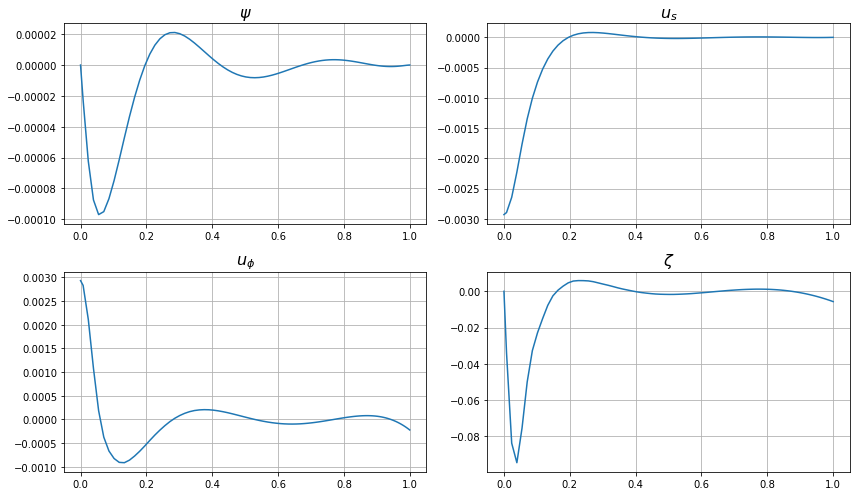

In [217]:
# plot_fields = [["Psi", "U_s", "U_p"],
#                ["Mss", "Mpp", "Msp"], 
#                ["Msz", "Mpz", None], 
#                ["zMss", "zMpp", "zMsp"], 
#                ["Bs_e", "Bp_e", "Bz_e"]]
# plot_fnames = [[None, "$u_s$", r"$u_\phi$"],
#                [None, None, None],
#                [None, None, None],
#                [None, None, None], 
#                [None, None, None],]
plot_fields = [["Psi", "U_s"],
               ["U_p", "Zeta"]]
plot_fnames = [[None, "$u_s$"],
               [r"$u_\phi$", r"$\zeta$"]]

# save_name = "./out/eigen/Malkus/Transformed/mode_radial_m3n5"
save_name = None
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*3.5))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        ax.plot(s_array, np.real(eigmode_eval[fname]))
        if np.abs(np.real(eigmode_eval[fname])).max() < 1e-5:
            ax.set_ylim([-1e-5, +1e-5])
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar_ptb[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.grid(True)

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Equatorial section

For Equatorial plane section, $z=0$. $s$ and $p$ form a mesh of grid points.

In [41]:
z_cst = 0
# s_array = np.linspace(0, 1, num=100)
xi_array, _ = specfun.roots_chebyt(100)
s_array = np.r_[0, np.sqrt((1 + xi_array)/2), 1]
p_array = np.linspace(0, 2*np.pi, num=400)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

Calculate all fields

In [42]:
def calc_field_equatorial(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, N_tmp = np.meshgrid(s_array, np.arange(field_nrange[fname]), indexing='ij')
    eval_tmp = field_f(S_tmp, 0., z_cst, N_tmp, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    eval_rad = np.sum(eval_tmp, axis=-1)
    eval_azm = np.exp(1j*physical_params[xpd.m]*p_array)
    return np.outer(eval_azm, eval_rad)
    # S_tmp, P_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([P_mesh,]*N_trial, axis=-1)
    # N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    # eval_tmp = field_f(S_tmp, P_tmp, z_cst, N_tmp, *[vec for vec in eigvec])
    # if np.array(eval_tmp).ndim == 0:
    #     return eval_tmp*np.ones_like(S_mesh[...,0])
    # eval_tmp[np.isnan(eval_tmp)] = 0.
    # return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_equatorial, inplace=False, metadata=True)

Plot all fields

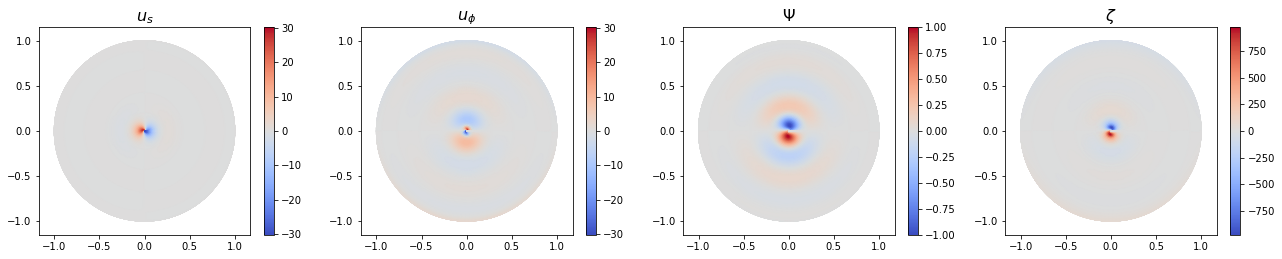

In [43]:
# plot_fields = [["Psi", "U_s", "U_p", "U_z"],
#                ["Mss", "Mpp", "Msp", "zMsp"], 
#                ["Msz", "Mpz", "zMss", "zMpp"], 
#                ["Bs_e", "Bp_e", "Bz_e", "Zeta"]]
# plot_fnames = [[None, r"$u_s$", r"$u_\phi$", r"$u_z$"],
#                [None, None, None, None], 
#                [None, None, None, None], 
#                [None, None, None, r"$\zeta$"]]
plot_fields = [["U_s", "U_p", "Psi", "Zeta"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", None, r"$\zeta$"],]

# save_name = "./out/eigen/Hydrodynamic/Reduced/mode_equatorial_m3n10"
save_name = None
override = False

# max_norm = max([np.abs(np.real(eigmode_eval[plot_fields[i_r][i_c]])).max() 
#                 for i_r in range(nrows) for i_c in range(ncols) 
#                 if plot_fields[i_r][i_c] is not None and plot_fields[i_r][i_c] != "Zeta"])
max_norm = np.abs(np.real(eigmode_eval["Psi"])).max()

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.7))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.abs(np.real(eigmode_eval[fname])).max() > 1e-5:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Meridional section

For meridional plane section, $\phi=Cst$. $s$ and $z$ form a mesh of grid points.

In [44]:
p_cst = np.pi/6
xi_array, _ = specfun.roots_chebyt(80)
r_array = np.r_[0, np.sqrt((1 + xi_array)/2), 1]
theta_array = np.linspace(0, np.pi, num=200)
R_mesh, T_mesh = np.meshgrid(r_array, theta_array)
S_mesh, Z_mesh = R_mesh*np.sin(T_mesh), R_mesh*np.cos(T_mesh)

Calculate only the velocity and vorticity fields;

In [45]:
def calc_field_meridional(fname, field_f):
    if fname not in ("U_s", "U_p", "U_z", "Zeta", "Psi"):
        return None
    N_trial = field_nrange[fname]
    S_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, p_cst, Z_tmp, N_tmp, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_meridional, inplace=False, metadata=True)

Plot fields.

Note: physically, only plotting the fields defined in 3-D space make sense. Therefore, none of the PG variables have meridional plot, as all of the fields are defined in 2-D (most in the unit disk, $B_r$ on the surface of the sphere).

The only field with full volumetric definition is the velocity field, which of course takes the form of the ansatz.

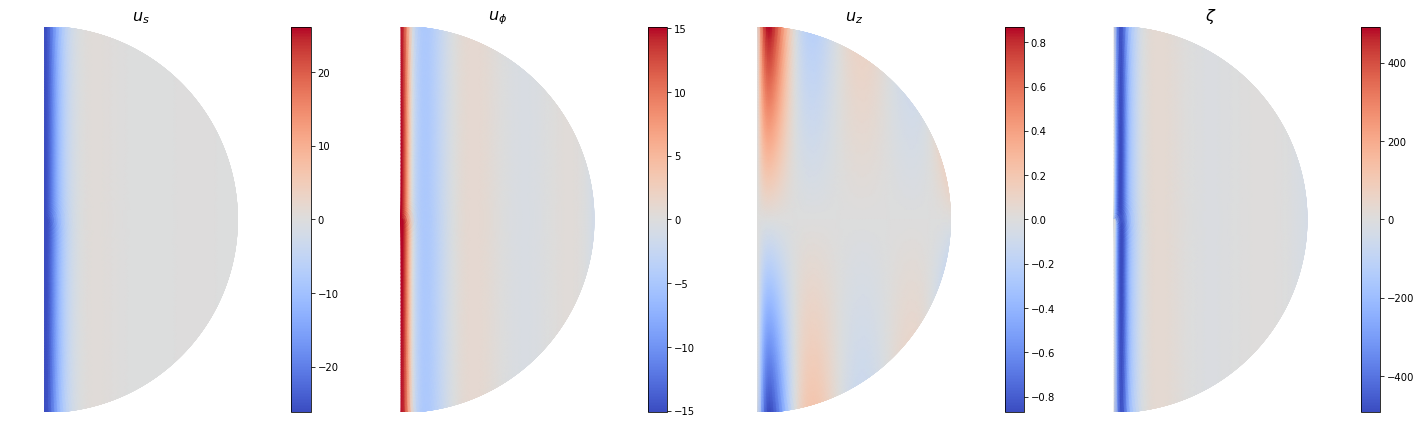

In [46]:
plot_fields = [["U_s", "U_p", "U_z", "Zeta"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$", r"$\zeta$"],]
# save_name = "./out/eigen/Hydrodynamic/Reduced/mode_meridional_m3n10"
save_name = None
override = False

force_symmetric_cmap = True

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*6))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.abs(np.real(eigmode_eval[fname])).max() > 1e-5:
            if force_symmetric_cmap:
                climit = np.max(np.abs(np.real(eigmode_eval[fname])/max_norm))
                cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.axis("equal")
        # ax.grid()
        ax.axis("off")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

---
## Eigenmode spectrum

Read in eigenvalue solutions

In [130]:
from pg_utils.numerics import matrices as nmatrix
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import params

eigen_files_list = [
    # "./out/eigen/Malkus/Transformed/eigen_m3_N5.h5", 
    # "./out/eigen/Malkus/Transformed/eigen_m3_N50.h5",
    "./out/eigen/Malkus/Reduced/eigen_m3_N50.h5",
    "./out/eigen/Malkus/Reduced/eigen_m3_N50_cpt.h5",
    # "./out/eigen/Malkus/Reduced/eigen_m3_N50_quad-eigen-p113.h5",
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m3_N5.h5", 
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m1_N50.h5",
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m2_N50.h5",
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m3_N50.h5", 
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m5_N50.h5",
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m10_N50.h5",
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m20_N50.h5",
    # "./out/eigen/Toroidal_Quadrupole/Transformed/eigen_m3_N20.h5",
    # "./out/eigen/Toroidal_Quadrupole/Transformed/eigen_m3_N50.h5",
    # "./out/eigen/Toroidal_Quadrupole/Reduced/eigen_m3_Le-2_N20.h5",
    # "./out/eigen/Toroidal_Quadrupole/Reduced/eigen_m3_Le-2_N50.h5",
    # "./out/eigen/Toroidal_Quadrupole/Reduced/eigen_m3_Le-2_N80.h5",
    # "./out/eigen/Poloidal_Dipole/Reduced/eigen_m3_N20.h5",
    # "./out/eigen/Poloidal_Dipole/Reduced/eigen_m3_N50.h5",
    # "./out/eigen/Poloidal_Dipole/Reduced/eigen_m3_N50_quad-eigen-p113_tmp.h5"
    # "./out/eigen/Poloidal_Dipole/Transformed/eigen_m3_N20.h5",
    # "./out/eigen/Poloidal_Dipole/Transformed/eigen_m3_N50.h5",
]
label_list = [
    # For instance, the truncation level can be used as labels
    # 5,
    # 10,
    20,
    # 50,
    "50 (prec=113 quadrature)"
    # 80,
    # 100
    # Or the labels can be e.g. azimuthal wavenumber
    # 1, 2, 3, 5, 10, 20
]

eig_val_list = list()
eig_vec_list = list()
cnames_list = list()
ranges_list = list()
params_list = list()
for idx, fname in enumerate(eigen_files_list):
    with h5py.File(fname, 'r') as f:
        eig_vals = f["eigval"][()]
        eig_vecs = f["eigvec"][()]
        if "bases" in f.keys():
            cnames = list(f["bases"]["names"].asstr()[()])
            ranges = f["bases"]["ranges"][()]
        if "azm" in f.attrs.keys():
            params_list.append({
                xpd.m: f.attrs["azm"], 
                params.Le :f.attrs["Le"]})
        else:
            params_list.append({parse_expr(key): f.attrs[key] for key in f.attrs.keys()})
    eig_val_list.append(eig_vals)
    eig_vec_list.append(eig_vecs)
    cnames_list.append(cnames)
    ranges_list.append(ranges)

### Sorting eigenmodes

East/west splitting. The following code block classifies the eigenvalues into
1. Eastwards modes and their eigenvalues (imaginary part smaller than a negative threshold)
2. Westwards modes and their eigenvalues (imaginary part greater than a positive threshold)

In [131]:
func_collections = [
    lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=-1e-7, transform_filter=np.imag, transform_sort=np.imag),
    lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=+1e-7, transform_filter=np.imag, transform_sort=np.imag)
]

Fast/slow splitting. The following code block classifies the eigenvalues into
1. Fast modes and their eigenvalues (absolute value of imaginary part greater than a threshold)
2. Slow modes and their eigenvalues (absolute value of imaginary part less than a threshold)

In [23]:
func_collections = [
    lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=1e+1, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), reversed=True),
    lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=1e+1, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), remove_zero=1e-9)
]

Collect the results according to the classification criterion

In [132]:
ds_vals_collections = [list() for func in func_collections]
ds_vecs_collections = [list() for func in func_collections]

for i_src, label in enumerate(label_list):
    eig_vals_classes = pproc.classify_eigens_criteria(eig_val_list[i_src], func_collections)
    eig_vecs_classes = [eig_vec_list[i_src][:, eig_class[1]] for eig_class in eig_vals_classes]
    eig_vals_classes = [eig_class[0] for eig_class in eig_vals_classes]
    for i_ds, ds_tmp in enumerate(ds_vals_collections):
        ds_vals_collections[i_ds].append(eig_vals_classes[i_ds])
        ds_vecs_collections[i_ds].append(nmatrix.LabeledBlockArray(eig_vecs_classes[i_ds], cnames_list[i_src], ranges_list[i_src]))

### Eigenvalue spectrum

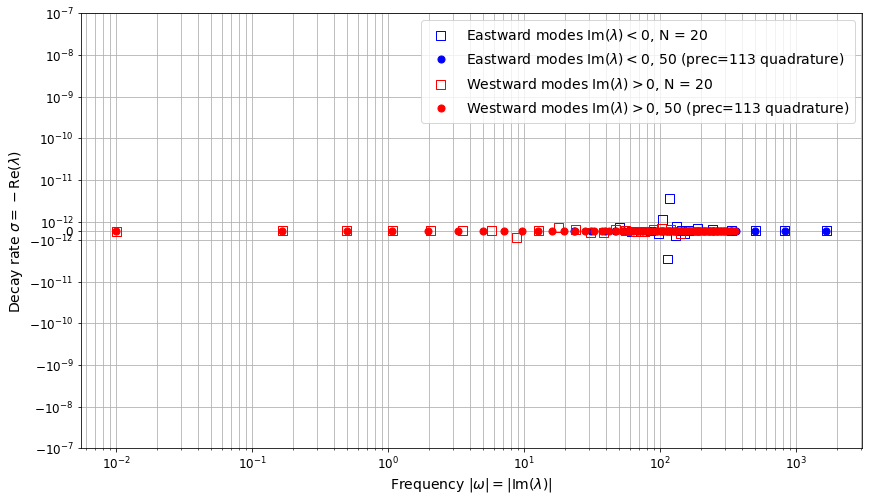

In [49]:
fig, ax = plt.subplots(figsize=(14, 8))
# save_name = "./out/eigen/Poloidal_Dipole/Spectrum_m3_Le-1.414e-4"
save_name = None
override = False

style_cfg = [
    [
        {'s': 80, "marker": 's', "edgecolors": 'b', "facecolors": "none", "linewidths": 1},
        {'s': 50, "marker": 'o', "edgecolors": 'b', "facecolors": "b", "linewidths": 1},
        {'s': 50, "marker": 'x', "color": 'b', "linewidths": 1},
    ],
    [
        {'s': 80, "marker": 's', "edgecolors": 'r', "facecolors": "none", "linewidths": 1},
        {'s': 50, "marker": 'o', "edgecolors": 'r', "facecolors": "r", "linewidths": 1},
        {'s': 50, "marker": 'x', "color": 'r', "linewidths": 1},
    ],
]
ds_name = [
    r"Eastward modes $\mathrm{Im}(\lambda) < 0$",
    r"Westward modes $\mathrm{Im}(\lambda) > 0$"
    # r"Fast modes $|\mathrm{Im}(\lambda)| > 1.$",
    # r"Slow modes $|\mathrm{Im}(\lambda)| < 1.$"
]

for i_ds in range(len(ds_vals_collections)):
    for i_src in range(len(label_list)):
        if style_cfg[i_ds][i_src] is None:
            continue
        label = "%s, %s" % (ds_name[i_ds], label_list[i_src]) if isinstance(label_list[i_src], str) else "%s, N = %d" % (ds_name[i_ds], label_list[i_src])
        ax.scatter(np.abs(np.imag(ds_vals_collections[i_ds][i_src])), -np.real(ds_vals_collections[i_ds][i_src]),
            **style_cfg[i_ds][i_src], label=label, zorder=5)
        # ax.scatter(np.imag(ds_vals_collections[i_ds][i_src]), -np.real(ds_vals_collections[i_ds][i_src]),
        #     **style_cfg[i_ds][i_src], label=label, zorder=5)

ax.set_xlabel(r"Frequency $|\omega| = |\mathrm{Im}(\lambda)|$", fontsize=14)
# ax.set_xlabel(r"Frequency $\omega = \mathrm{Im}(\lambda)$", fontsize=14)
ax.set_ylabel(r"Decay rate $\sigma = -\mathrm{Re}(\lambda)$", fontsize=14)

ax.set_xscale('log')
# ax.set_xscale('symlog', linthresh=1e-3, linscale=.1)
ax.set_yscale('symlog', linthresh=1e-12, linscale=.2)
# ax.set_xlim([4, 6])
ax.set_ylim([-1e-7, +1e-7])
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(which="both")
ax.legend(fontsize=14)

if save_name is not None:
    if os.path.exists(save_name + '.pdf') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.pdf', format="pdf", bbox_inches="tight")
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")
plt.show()

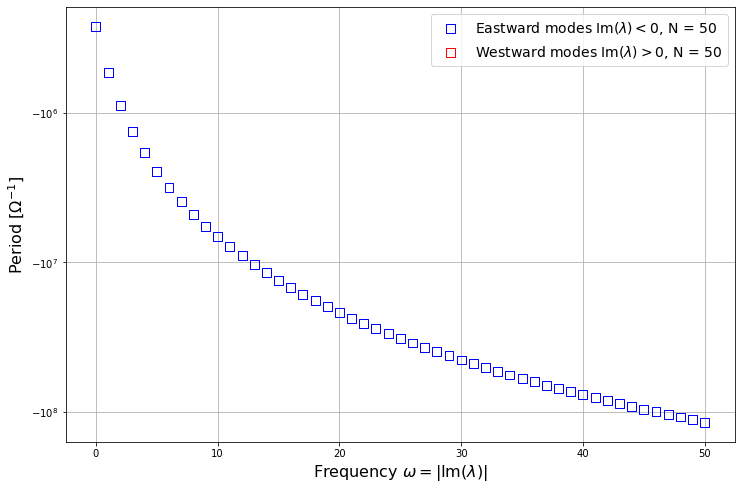

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))

style_cfg = [
    [
        {'s': 80, "marker": 's', "edgecolors": 'b', "facecolors": "none", "linewidths": 1},
        {'s': 60, "marker": 'o', "edgecolors": 'b', "facecolors": "none", "linewidths": 1},
        {'s': 30, "marker": 'x', "color": 'b', "linewidths": 1},
    ],
    [
        {'s': 80, "marker": 's', "edgecolors": 'r', "facecolors": "none", "linewidths": 1},
        {'s': 60, "marker": 'o', "edgecolors": 'r', "facecolors": "none", "linewidths": 1},
        {'s': 30, "marker": 'x', "color": 'r', "linewidths": 1},
    ],
]
ds_name = [
    r"Eastward modes $\mathrm{Im}(\lambda) < 0$",
    r"Westward modes $\mathrm{Im}(\lambda) > 0$"
]

for i_ds in range(len(ds_vals_collections)):
    for i_src in range(len(label_list)):
        if style_cfg[i_ds][i_src] is None:
            continue
        ax.scatter(
            np.arange(ds_vals_collections[i_ds][i_src].size),
            np.sign(np.imag(ds_vals_collections[i_ds][i_src]))*2*np.pi/(params_list[i_src][params.Le]*np.abs(np.imag(ds_vals_collections[i_ds][i_src]))),
            **style_cfg[i_ds][i_src], label="%s, N = %d" % (ds_name[i_ds], label_list[i_src]), zorder=5)

ax.set_xlabel(r"Frequency $\omega = |\mathrm{Im}(\lambda)|$", fontsize=16)
ax.set_ylabel(r"Period [$\Omega^{-1}$]", fontsize=16)

ax.set_yscale('symlog', linthresh=20, linscale=0.1)
# ax.set_xlim([-1, 20])
# ax.set_ylim([1e+1, 1e+3])

ax.grid(which="both")
ax.legend(fontsize=14)

plt.show()

Inspect eigenvalues

In [53]:
class_idx = 1
trunc_N = min([ds_vals_collections[class_idx][i_src].size for i_src in range(len(label_list))])
trunc_N = 20

df = pd.DataFrame(data={label_list[i_src]: ds_vals_collections[class_idx][i_src][:trunc_N] for i_src in range(len(label_list))})
df.style.format(formatter=lambda x: "{0.real:.2e},{0.imag:.7e}j".format(x))

,20,50 (prec=113 quadrature)
0,"2.97e-14,9.9971881e-03j","2.86e-27,9.9963789e-03j"
1,"-2.39e-14,1.6626529e-01j","8.16e-28,1.6616834e-01j"
2,"1.47e-14,4.9546531e-01j","-1.64e-27,4.9369149e-01j"
3,"-5.96e-14,1.0811943e+00j","-2.24e-26,1.0663896e+00j"
4,"5.36e-15,2.0391339e+00j","-4.41e-27,1.9645666e+00j"
5,"-9.73e-15,3.5211192e+00j","-4.09e-26,3.2582467e+00j"
6,"-6.27e-14,5.6986642e+00j","-1.60e-25,4.9838051e+00j"
7,"6.95e-13,8.7278883e+00j","-6.61e-25,7.1326841e+00j"
8,"-5.08e-14,1.2711911e+01j","2.28e-24,9.6810124e+00j"
9,"-3.37e-13,1.7684471e+01j","-1.67e-24,1.2624811e+01j"


### Eigen solution filtering

1. Boyd's drift method:

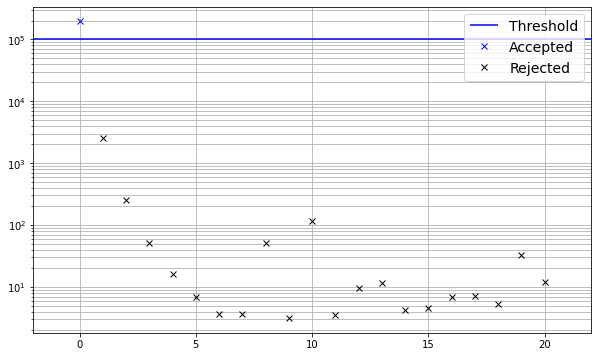

In [52]:
class_idx = 1

src_idx_base = 0
src_idx_comp = 1

eig_drift, eig_nearest = nutils.eigen_drift(ds_vals_collections[class_idx][src_idx_base], ds_vals_collections[class_idx][src_idx_comp])
drift_thresh = 1e+5
drift_filter = 1./(eig_drift + 1e-16) > drift_thresh

fig, ax = plt.subplots(figsize=(10, 6))
ax.hlines([drift_thresh,], -2, eig_drift.size + 1, 'b', label="Threshold")
ax.semilogy(np.arange(eig_drift.size)[drift_filter], 1./(eig_drift[drift_filter] + 1e-16), 'bx', label="Accepted")
ax.semilogy(np.arange(eig_drift.size)[~drift_filter], 1./(eig_drift[~drift_filter] + 1e-16), 'kx', label="Rejected")
ax.grid(which="both")
ax.set_xlim([-2, eig_drift.size + 1])
ax.legend(fontsize=14)

plt.show()

2. Maximum trailing rate of exponential convergence

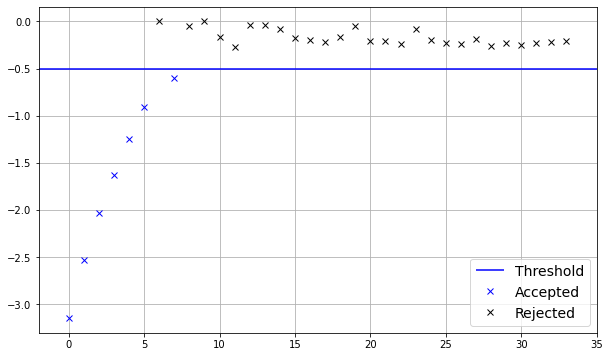

In [39]:
class_idx = 0

src_idx = 0

tail_exp_rates = nutils.spec_tail_exp_rate(ds_vecs_collections[0][0]["Psi"])
rate_thresh = -0.5
rate_filter = tail_exp_rates < rate_thresh

fig, ax = plt.subplots(figsize=(10, 6))
ax.hlines([rate_thresh,], -2, tail_exp_rates.size + 1, 'b', label="Threshold")
ax.plot(np.arange(tail_exp_rates.size)[rate_filter], tail_exp_rates[rate_filter], 'bx', label="Accepted")
ax.plot(np.arange(tail_exp_rates.size)[~rate_filter], tail_exp_rates[~rate_filter], 'kx', label="Rejected")
ax.grid(which="both")
ax.set_xlim([-2, tail_exp_rates.size + 1])
ax.legend(fontsize=14)

plt.show()

Apply the filter (optional)

In [18]:
final_filter = drift_filter

# Filter eigenvalues
ds_vals_collections[class_idx][src_idx_base] = ds_vals_collections[class_idx][src_idx_base][final_filter]
ds_vals_collections[class_idx][src_idx_comp] = ds_vals_collections[class_idx][src_idx_comp][eig_nearest[final_filter]]

# Filter eigenvectors
ds_vecs_collections[class_idx][src_idx_base]._array = ds_vecs_collections[class_idx][src_idx_base]._array[:, final_filter]
ds_vecs_collections[class_idx][src_idx_comp]._array = ds_vecs_collections[class_idx][src_idx_comp]._array[:, eig_nearest[final_filter]]

### Eigenvalue plot

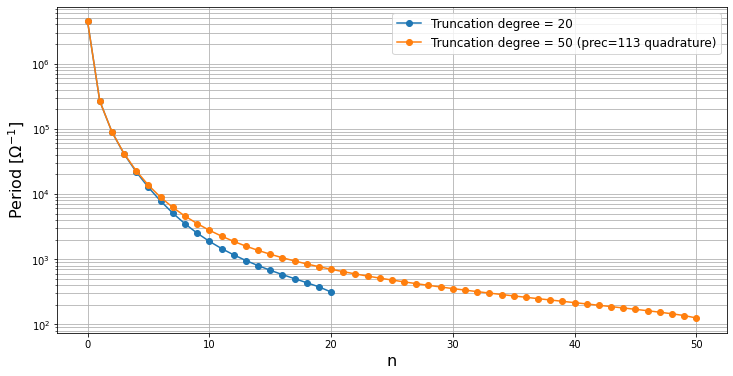

In [54]:
class_idx = 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
# save_name = "./out/cases/Hydrodynamic/Recipe_Conjugate/m3_leading_10_eigenmodes"
save_name = None

scale = 1/params_list[0][params.Le]
# scale = 1

for i_src in range(len(label_list)):
    ax.plot(2*np.pi*scale/np.abs(np.imag(ds_vals_collections[class_idx][i_src])), 
            'o-',
            label="Truncation degree = {}".format(label_list[i_src]))

ax.set_yscale("log")
ax.set_xlabel("n", fontsize=16)
ax.set_ylabel(r"Period [$\Omega^{-1}$]", fontsize=16)
ax.legend(fontsize=12)
ax.grid(which="both")

# ax.set_xlim([-1, 20])
# ax.set_ylim([10, 1e+3])

if save_name is not None:
    plt.savefig(save_name + ".pdf", format="pdf", bbox_inches="tight")
    plt.savefig(save_name + ".png", format="png", bbox_inches="tight", dpi=150)

plt.show()

Mimicing the wavenumber-period plot

In [ ]:
class_idx = 0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
# save_name = "./out/eigen/Hydrodynamic/Period_wavenumber_plot_m20_n10"
save_name = None

# scale = 1/params_list[i_src][params.Le]
scale = 1

plot_orders = [0, 2, 5, 9]

for order in plot_orders:
    ax.semilogy(label_list,
        2*np.pi*scale/np.abs(np.imag([ds[order] for ds in ds_vals_collections[class_idx]])), 
        's--',
        label="n = {:d}".format(order))

ax.set_xscale("log")
ax.set_xlabel("Azimuthal wavenumber m", fontsize=16)
ax.set_ylabel(r"Period [$\Omega^{-1}$]", fontsize=16)
ax.legend(fontsize=14)
ax.grid(which="both")

# ax.set_xlim([-1, 20])
# ax.set_ylim([10, 1e+3])

if save_name is not None:
    plt.savefig(save_name + ".pdf", format="pdf", bbox_inches="tight")
    plt.savefig(save_name + ".png", format="png", bbox_inches="tight", dpi=150)

plt.show()

### Spectrum of the solution

In [105]:
ds_vecs_collections[0][1]["F_ext"][:, 49]

array([ 7.37674579e-02+4.58790096e-02j,  1.06443341e-01+6.62014823e-02j,
        1.38999367e-01+8.64494109e-02j,  1.71398274e-01+1.06599621e-01j,
        2.03602549e-01+1.26628781e-01j,  2.35574194e-01+1.46513260e-01j,
        2.67274985e-01+1.66229283e-01j,  2.98665741e-01+1.85752482e-01j,
        3.29707404e-01+2.05058566e-01j,  3.60358968e-01+2.24122032e-01j,
        3.90580579e-01+2.42918092e-01j,  4.20328473e-01+2.61419528e-01j,
        4.49562277e-01+2.79601230e-01j,  4.78234111e-01+2.97433421e-01j,
        5.06303726e-01+3.14891066e-01j,  5.33717153e-01+3.31940602e-01j,
        5.60435426e-01+3.48557793e-01j,  5.86395658e-01+3.64703526e-01j,
        6.11562072e-01+3.80355552e-01j,  6.35858815e-01+3.95466694e-01j,
        6.59256256e-01+4.10018522e-01j,  6.81659840e-01+4.23952231e-01j,
        7.03050515e-01+4.37255969e-01j,  7.23306886e-01+4.49854237e-01j,
        7.42427028e-01+4.61745839e-01j,  7.60251129e-01+4.72831379e-01j,
        7.76803991e-01+4.83126283e-01j,  7.91870788

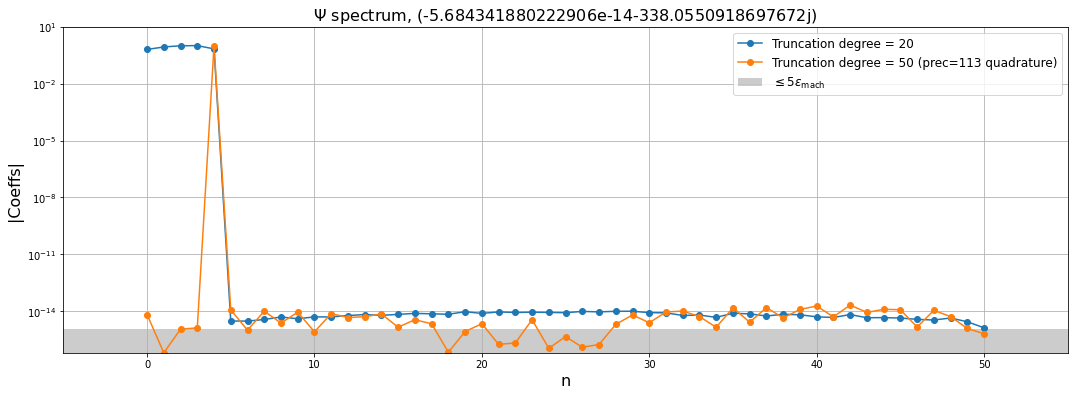

In [133]:
# Choose which field to check
class_idx = 0
mode_idx = [4,4]
field_name = "F_ext"
field_title = r"$\Psi$"

# save_name = "./out/eigen/Hydrodynamic/Reduced/spectrum_m3n%d" % mode_idx
save_name = None

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

for i_src in range(len(label_list)):
    eig_cfs = ds_vecs_collections[class_idx][i_src][field_name]
    # if eig_cfs.shape[1] <= 50:
    #     continue
    ax.plot(np.abs(eig_cfs[:, mode_idx[i_src]])/np.max(np.abs(eig_cfs[:, mode_idx[i_src]])), 
            'o-', label="Truncation degree = {}".format(label_list[i_src]))

coeff_min = np.abs(np.abs(eig_cfs[:, mode_idx[i_src]])).min()/np.max(np.abs(eig_cfs[:, mode_idx[i_src]]))
ax.fill_between([-5, 50+5], min([1e-20, coeff_min])*np.ones(2), 5*np.finfo(np.float64).eps*np.ones(2), 
    facecolor="gray", alpha=0.4, label="$\leq 5\epsilon_{\mathrm{mach}}$")

ax.set_title(r"{:s} spectrum, {}".format(field_title, ds_vals_collections[class_idx][-1][mode_idx[1]]), fontsize=16)
ax.set_yscale("log")
ax.set_xlabel("n", fontsize=16)
ax.set_ylabel(r"|Coeffs|", fontsize=16)
ax.legend(fontsize=12)
ax.grid(which="both")

ax.set_xlim([-5, 50+5])
ax.set_ylim([min([1e-16, coeff_min]), 10])

if save_name is not None:
    plt.savefig(save_name + ".pdf", format="pdf", bbox_inches="tight")
    plt.savefig(save_name + ".png", format="png", bbox_inches="tight", dpi=150)

plt.show()

---

## Miscellaneous

### Peek eigenvalues

In [3]:
matrix_files = [
    "./out/eigen/Hydrodynamic/Reduced/eigen_m3_N50_quad-eigen-p113.h5",
    "./out/eigen/Hydrodynamic/Reduced/eigen_m3_N50_quad-eigen-p113_tmp.h5"
    # "./out/eigen/Malkus/Reduced/eigen_m3_N50.h5",
    # "./out/eigen/Malkus/Reduced/eigen_m3_N50_quad-eigen-p113.h5",
    # "./out/eigen/Poloidal_Dipole/Reduced/eigen_m3_N50_quad-eigen-p113.h5",
    # "./out/eigen/Poloidal_Dipole/Reduced/eigen_m3_N50_v3.h5",
    # "./out/eigen/Poloidal_Dipole/Reduced/eigen_m3_N50_v4.h5"
]

eig_vals_list = list()
eig_vecs_list = list()

for fname in matrix_files:
    with h5py.File(fname, 'r') as fread:
        eig_vals_list.append(fread["eigval"][()])
        eig_vecs_list.append(fread["eigvec"][()])

In [6]:
np.min(eig_vals_list[0] == eig_vals_list[1])

True

In [21]:
eig_vals_list[0][:5]

array([ 0.00000000e+00-2352.94530146j,  1.17961196e-14-1165.05656863j,
        0.00000000e+00 -701.76751072j, -5.68434189e-14 -470.60765949j,
        5.68434189e-14 -338.05509187j])

In [22]:
eig_vals_list[1][:5]

array([-3.05733508e-36-2352.94530146j,  3.33023966e-36-1165.05656863j,
       -2.09787364e-35 -701.76751072j,  3.23562150e-37 -470.60765949j,
       -3.40081568e-35 -338.05509187j])

In [48]:
eig_vals_list[2][:5]

array([ 2.19106201e-31-1663.76606897j, -7.53626345e-30 -823.98805209j,
       -3.89068626e-26 -496.89843267j,  3.33962186e-19 -357.96745654j,
       -3.30946945e-19 +354.18985239j])

### Matrix visualization

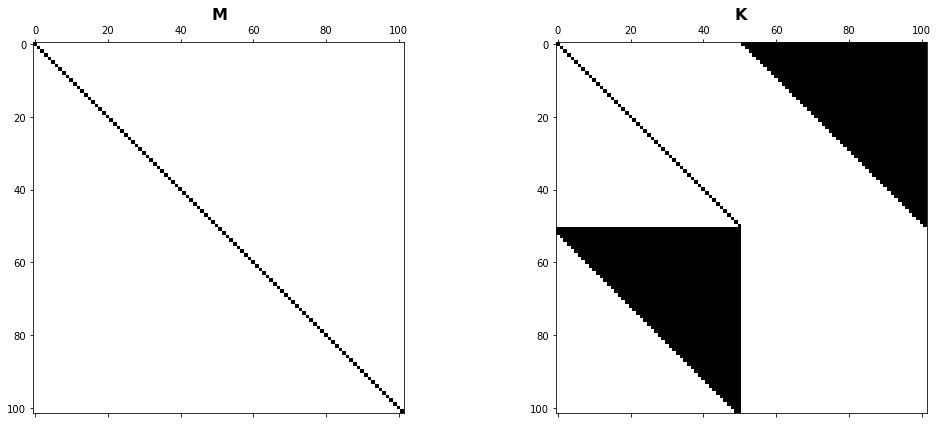

In [24]:
from pg_utils.numerics import io as num_io

# matrix_file = "./out/eigen/Malkus/Transformed/matrix_m1_N50.h5"
# matrix_file = "./out/cases/Malkus/Reduced_sys/Matrix_eval.h5"
# matrix_file = "./out/cases/Hydrodynamic/Recipe_Conjugate/Matrix_eval_N10.h5"
# matrix_file = "./out/eigen/Hydrodynamic/Transformed/matrix_m3_N5.h5"
# matrix_file = "./out/eigen/Toroidal_Quadrupole/Transformed/matrix_m3_N20.h5"
# matrix_file = "./out/eigen/Toroidal_Quadrupole/Reduced/matrix_m3_Le-2_N50.h5"
matrix_file = "./out/eigen/Poloidal_Dipole/Reduced/matrix_m3_N50_p-quad.h5"

with h5py.File(matrix_file, 'r') as fread:
    M_tmp = num_io.matrix_load_from_group(fread["M"])
    K_tmp = num_io.matrix_load_from_group(fread["K"])
    if not isinstance(M_tmp, np.ndarray):
        M_tmp = M_tmp.todense()
        K_tmp = K_tmp.todense()

visual_prec = 1e-12
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax = axes[0]
ax.spy(M_tmp, precision=visual_prec)
ax.set_title(r"$\mathbf{M}$", fontsize=16)

ax = axes[1]
ax.spy(K_tmp, precision=visual_prec)
ax.set_title(r"$\mathbf{K}$", fontsize=16)

plt.tight_layout()
# plt.savefig("./out/imgs/sparsity__hydrodynamic_cg.png", format="png", bbox_inches="tight")
plt.show()

C:\Users\gentle\AppData\Local\Temp\ipykernel_14484\2896541416.py:32: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(np.abs(M_tmp)), vmin=vrange[0], vmax=vrange[1])
C:\Users\gentle\AppData\Local\Temp\ipykernel_14484\2896541416.py:37: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.abs(K_tmp)), vmin=vrange[0], vmax=vrange[1])


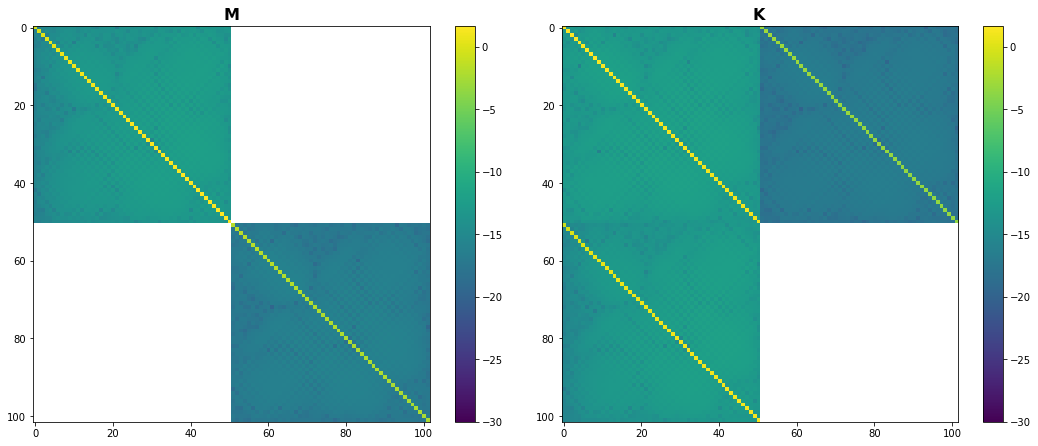

In [122]:
from pg_utils.numerics import io as num_io
import gmpy2 as gp

matrix_file = "./out/eigen/Malkus/Reduced/matrix_m3_N50_cpt.h5"
with h5py.File(matrix_file, 'r') as fread:
    M_tmp = num_io.matrix_load_from_group(fread["M"])
    K_tmp = num_io.matrix_load_from_group(fread["K"])
    if not isinstance(M_tmp, np.ndarray):
        M_tmp = M_tmp.todense()
        K_tmp = K_tmp.todense()
# M_tmp[np.abs(M_tmp) < 1e-10] = 0.
# K_tmp[np.abs(K_tmp) < 1e-10] = 0.

# matrix_file = "./out/eigen/Malkus/Reduced/matrix_m3_N50_quad-p113.pkl"
# with open(matrix_file, 'rb') as fread:
#     matrix_obj = pickle.load(fread)
#     M_tmp = num_io.parse_coo(matrix_obj["M"])
#     K_tmp = num_io.parse_coo(matrix_obj["K"])
# M_tmp = nutils.to_dense_gmpy2(M_tmp, prec=113)
# K_tmp = nutils.to_dense_gmpy2(K_tmp, prec=113)

# M_tmp[np.abs(M_tmp) < 1e-25] = gp.mpc("0.", 113)
# K_tmp[np.abs(K_tmp) < 1e-25] = gp.mpc("0.", 113)

M_tmp = M_tmp.astype(np.complex128)
K_tmp = K_tmp.astype(np.complex128)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
vrange = [-30, None]

ax = axes[0]
im = ax.imshow(np.log10(np.abs(M_tmp)), vmin=vrange[0], vmax=vrange[1])
ax.set_title(r"$\mathbf{M}$", fontsize=16)
plt.colorbar(im, ax=ax)

ax = axes[1]
ax.imshow(np.log10(np.abs(K_tmp)), vmin=vrange[0], vmax=vrange[1])
ax.set_title(r"$\mathbf{K}$", fontsize=16)
plt.colorbar(im, ax=ax)

plt.tight_layout()
# plt.savefig("./out/eigen/Malkus/Reduced/matview_prec-np.png", format="png", dpi=150, bbox_inches="tight")
plt.show()

### Output to 3-D visualization

In [115]:
r_array = np.arange(0.05, 1, 0.1)
theta_array = np.arange(0, 181, 5)
phi_array = np.arange(0, 360, 5)

R_mesh, Phi_mesh, Theta_mesh = np.meshgrid(r_array, np.radians(phi_array), np.radians(theta_array), indexing='ij')
S_mesh = R_mesh*np.sin(Theta_mesh)
Z_mesh = R_mesh*np.cos(Theta_mesh)

def calc_field_3d(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Phi_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, Z_tmp, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

Zeta_mesh = calc_field_3d("Zeta", field_func.Zeta)
Uz_mesh = calc_field_3d("U_z", field_func.U_z)

In [117]:
np.savez("./out/cases/Malkus/3darray.npz", r_array=r_array, theta_array=theta_array, phi_array=phi_array, Zeta=Zeta_mesh, Uz=Uz_mesh)